# Astrophysical Gamma-Ray Background

This notebook details how to construct a basic astrophysical background for use in Dark Matter parameter inference for CTA data from the Galactic Centre. The whole background for an analysis would require these components as well as a component for the rate/probability of mis-identified cosmic-rays. This is detailed further in the `prior_class` notebook. 

For now we split the astrophysical background into two components: the diffuse background and the localised source background. This notebook will detail how we construct interpolation functions for the background that are then used within the prior classes as a kind of look-up table.

## Localised source background

As the CTA is an imaging atmospheric Cherenkov Telescope (IACT) the localised source background from another IACT, the H.E.S.S experiment, would be a relevant source of localised source background. We do this by extracting the sources in the H.E.S.S catalogue within a reasonable distance of the Galactic Centre. This is mostly done with the use of the `Gammapy` package functions but the base files used to construct both this background and the diffuse background are contained within the `gammabayes/package_data` folder.

We first import the needed packages and functions to extract the H.E.S.S source catalogue.

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord
# from regions import CircleSkyRegion
import matplotlib.pyplot as plt

# %matplotlib inline
# from gammapy.datasets import Datasets, MapDataset
# from gammapy.modeling.models import (
#     PowerLawNormSpectralModel,
#     SkyModel,
#     TemplateSpatialModel,
# )
from gammapy.catalog import SourceCatalogHGPS


# %matplotlib inline
import numpy as np
from gammapy.maps import Map, MapAxis, WcsGeom



plt.rc('text', usetex=True)
plt.rc('font', family='serif')

We then import some helpful auxillary functions that aren't necessarily needed but make the code much simpler and efficient.

In [2]:
from scipy import interpolate
from scipy.integrate import simps
from scipy import special
from matplotlib.colors import LogNorm

Now that we have the setup completed, we can create an object that contains the whole H.E.S.S. catalogue by extracting them from the `hgps_catalog_v1.fits.gz` file within the `GammaBayes` package data folder and then convert them to source models.

In [4]:
hess_catalog = SourceCatalogHGPS("../gammabayes/package_data/hgps_catalog_v1.fits.gz")

hess_models = hess_catalog.to_models()

print(f"\nThere are {len(hess_models)} sources within the HGPS.")

/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lpin0002/anaconda3/envs/testywesty/lib/python3.11/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)



There are 96 sources within the HGPS.


At the moment the analysis is discrete, so we define axes along which we sample these models for use within the analysis. Default axes are contained within the `gammabayes/utils.py` file.

In [5]:
from gammabayes.utils import log10eaxistrue, longitudeaxistrue, latitudeaxistrue

`Gammapy` then uses some specific objects to define where to evaluate models. We won't go into too much detail here, but more information can be found within the  `Gammapy` documentation.

In [8]:
trueenergyaxis = 10**log10eaxistrue*u.TeV

energy_axis_true = MapAxis.from_nodes(trueenergyaxis, interp='log', name="energy_true")

HESSgeom = WcsGeom.create(
    skydir=SkyCoord(0, 0, unit="deg", frame='galactic'),
    binsz=longitudeaxistrue[1]-longitudeaxistrue[0],
    width=(longitudeaxistrue[-1]-longitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0], latitudeaxistrue[-1]-latitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0]),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis_true],
)

HESSmap = Map.from_geom(HESSgeom)
HESSmap

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (70, 60, 341)
	ndim  : 3
	unit  : 
	dtype : float32

Our, and `Gammapy`'s default energy axes are log-spaced. Let's have a quick look at specific values within the axis.

In [11]:
# The energy axis that has actually been stored
hessenergyaxis = energy_axis_true.center.value 

# Calculating the log_{10} values of this axis and looking at some of the differences between values. They should all be equal
np.diff(np.log10(hessenergyaxis))[:50]

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

Let's have a quick look at one of the models we've extracted and what information is contained within it.

In [12]:
print(hess_models[0])

SkyModel

  Name                      : HGPSC 001
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      1.354   +/-    0.08             
    amplitude                     :   1.15e-12   +/- 3.3e-13 1 / (TeV s cm2)
    reference             (frozen):      1.697       TeV         
    lambda_                       :      0.082   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    263.969   +/-    0.02 deg         
    lat_0                         :     -3.344   +/-    0.03 deg         
    sigma                         :      0.237   +/-    0.02 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         




So we have information on the:
- source name (HGPSC 001)
- spectral model (Exponential Cut Off Power Law)
- spatial model (Gaussian)
- model parameters

What we want is to extract the sources near the Galactic Centre, essentially those with lon_0 < 5 deg and lat_0 < 5 deg in the model parameters above that represent the centre of the source.

In [13]:


count=0 # To keep track of the number of sources satisfying the conditions

full_hess_flux = 0 #Extracting the flux values for the sources along the axes previously defined

for idx, model in enumerate(hess_models):
    
    # We will store the longitude 'l' and latitude 'b' values of the source
    temp_l_value = model.spatial_model.position.l.value
    temp_b_value = model.spatial_model.position.b.value
    
    
    # The unit convention for the longitude works as 357, 358, 359, 0, 1, 2
        # we will make it so that it's -3, -2, -1, 0, 1, 2
    if temp_l_value>180:
        temp_l_value=temp_l_value-360
        
        
    # If the location of the source satisfies the criteria above then we start to store it's flux values
    if np.abs(temp_l_value)<5 and np.abs(temp_b_value)<5:
        
        try:
            # We extract the flux by assigning it to the HESSmap object
            HESSmap.quantity = model.evaluate_geom(HESSmap.geom)
            
            # We can then extract the actual values by referencing the data of this object
            startdata = HESSmap.data
            
            # Removing nan values, '~' is a shortcut for 'not'
            data = startdata[~np.isnan(startdata)]
            
            # If statement to catch sources that have no obervable flux within the region
            if data.size!=0:
                
                # Making sure the data shape is consistent
                data = data.reshape(startdata.shape)
                
                # Adding the flux from this model to the total flux
                full_hess_flux+=data
                
        except:
            print("Something weird happened")
            print(idx, '\n\n')
            
        count+=1
        
# Transposing the longitude and latitude values such that the order of indices goes [logenergy_index, longitude_index, latitude_index]
fullhessdataset = np.transpose(full_hess_flux, axes=(0,2,1))

In [10]:
hessgeom = HESSmap.geom
hesslonvals = hessgeom.get_coord().lon.value[0][0]
hesslonvals = hesslonvals[::-1]
hesslonvals[hesslonvals>180] = hesslonvals[hesslonvals>180]-360
# print("lon vals", hesslonvals)

hesslatvals = hessgeom.get_coord().lat.value[0][:,0]
# print("lat vals", hesslatvals)
print(hesslonvals.shape)
print(hesslatvals.shape)

(35,)
(30,)


In [14]:
HESSmap.quantity.unit

Unit("1 / (TeV s sr cm2)")

In [12]:
fullhessdataset[0,0,0]

4.413259745288375e-205

(35,) (30,) (35, 30)


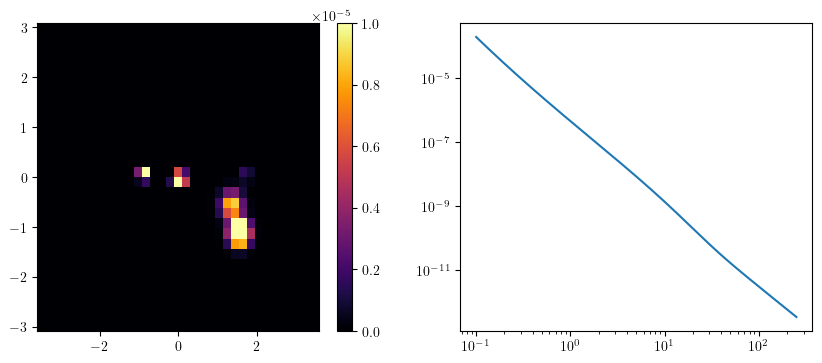

In [13]:
from scipy.ndimage import gaussian_filter

blurred_hess_data = fullhessdataset
print(hesslonvals.shape, hesslatvals.shape, blurred_hess_data[0].shape)
# Factor of 1e6 is so it matches with fermi backgrounds which are 1/MeV
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.pcolormesh(hesslonvals, 
               hesslatvals, 
               np.max(blurred_hess_data, axis=0).T, cmap='inferno', vmax=1e-5)
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(hessenergyaxis,  np.sum(blurred_hess_data, axis=(1,2)))
plt.loglog()
plt.show()

# Diffuse Background Extraction

In [5]:
def powerlaw(energy, index, phi0=1):
    return phi0*energy**(index)

In [15]:
# template_diffuse = TemplateSpatialModel.read(
#     filename="gll_iem_v06_gc.fits.gz", normalize=False
# )

template_diffuse = TemplateSpatialModel.read(
    filename="gll_iem_v06_gc.fits.gz", normalize=False
)

print(template_diffuse.map)

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
)

template_diffuse

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (120, 64, 30)
	ndim  : 3
	unit  : 1 / (cm2 MeV s sr)
	dtype : >f4



In [16]:
fermievaluated = np.flip(np.transpose(diffuse_iem.evaluate_geom(goodgeom), axes=(0,2,1)), axis=1)
fermiaveraged = special.logsumexp(np.log(fermievaluated.value.T)+10**log10eaxistrue+np.log(np.log(10))+log10eaxistrue[1]-log10eaxistrue[0], axis=2).T
fermiaveraged.shape

fermiaveraged = fermiaveraged-special.logsumexp(fermiaveraged+np.log(longitudeaxistrue[1]-longitudeaxistrue[0])+np.log(latitudeaxistrue[1]-latitudeaxistrue[0]))
fermifull = np.exp(fermiaveraged[np.newaxis, :, :]+np.log(powerlaw(10**log10eaxistrue, index=-2.41, phi0=1.36*1e-8))[:, np.newaxis, np.newaxis])
fermifull.shape

(341, 35, 30)

In [17]:
fermifull[1,0]

array([3.05447766e-08, 3.57513072e-08, 3.80180417e-08, 3.90029182e-08,
       4.24108705e-08, 4.41952669e-08, 5.08952512e-08, 5.46836566e-08,
       5.57016977e-08, 6.09100252e-08, 6.37111544e-08, 7.74175505e-08,
       9.32920946e-08, 1.08813639e-07, 1.34855785e-07, 1.37817491e-07,
       1.34486810e-07, 1.29034156e-07, 1.04092096e-07, 7.99036229e-08,
       6.98090950e-08, 5.51769164e-08, 4.62696611e-08, 4.39752112e-08,
       3.76064810e-08, 3.55568547e-08, 3.35502604e-08, 3.27063786e-08,
       2.86799487e-08, 2.62766932e-08])

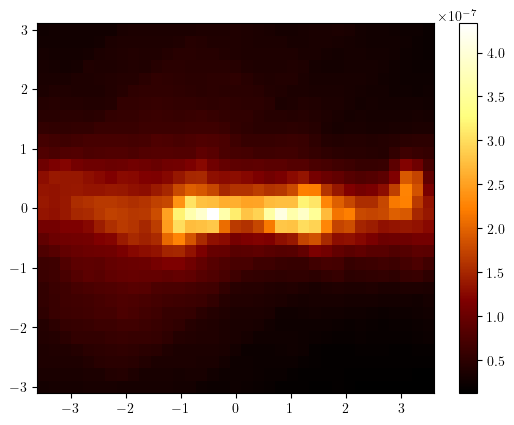

In [18]:
plt.figure()
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, fermifull[1].T, cmap='afmhot')
plt.colorbar()
plt.show()

In [19]:
fermievaluated = fermievaluated.to(1/u.TeV/u.s/u.sr/(u.cm**2))

In [20]:
fermievaluated[0,0,0]

<Quantity 5.41328185e-07 1 / (cm2 s sr TeV)>

In [21]:
fermilonaxistemp = np.unique(goodgeom.to_image().get_coord().lon.value)
firstover180idx = np.where(fermilonaxistemp>180)[0][0]
fermilonaxistemp[fermilonaxistemp>180] = fermilonaxistemp[fermilonaxistemp>180]-360
fermilonaxistemp.sort()
fermilonaxistemp.shape
fermilonaxis = fermilonaxistemp
fermilonaxis

array([-3.5       , -3.29411765, -3.08823529, -2.88235294, -2.67647059,
       -2.47058824, -2.26470588, -2.05882353, -1.85294118, -1.64705882,
       -1.44117647, -1.23529412, -1.02941176, -0.82352941, -0.61764706,
       -0.41176471, -0.20588235,  0.        ,  0.20588235,  0.41176471,
        0.61764706,  0.82352941,  1.02941176,  1.23529412,  1.44117647,
        1.64705882,  1.85294118,  2.05882353,  2.26470588,  2.47058824,
        2.67647059,  2.88235294,  3.08823529,  3.29411765,  3.5       ])

In [22]:
fermilataxis = goodgeom.get_coord().lat.value[0][:,0]
fermilataxis

array([-2.98529412, -2.77941176, -2.57352941, -2.36764706, -2.16176471,
       -1.95588235, -1.75      , -1.54411765, -1.33823529, -1.13235294,
       -0.92647059, -0.72058824, -0.51470588, -0.30882353, -0.10294118,
        0.10294118,  0.30882353,  0.51470588,  0.72058824,  0.92647059,
        1.13235294,  1.33823529,  1.54411765,  1.75      ,  1.95588235,
        2.16176471,  2.36764706,  2.57352941,  2.77941176,  2.98529412])

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:653: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


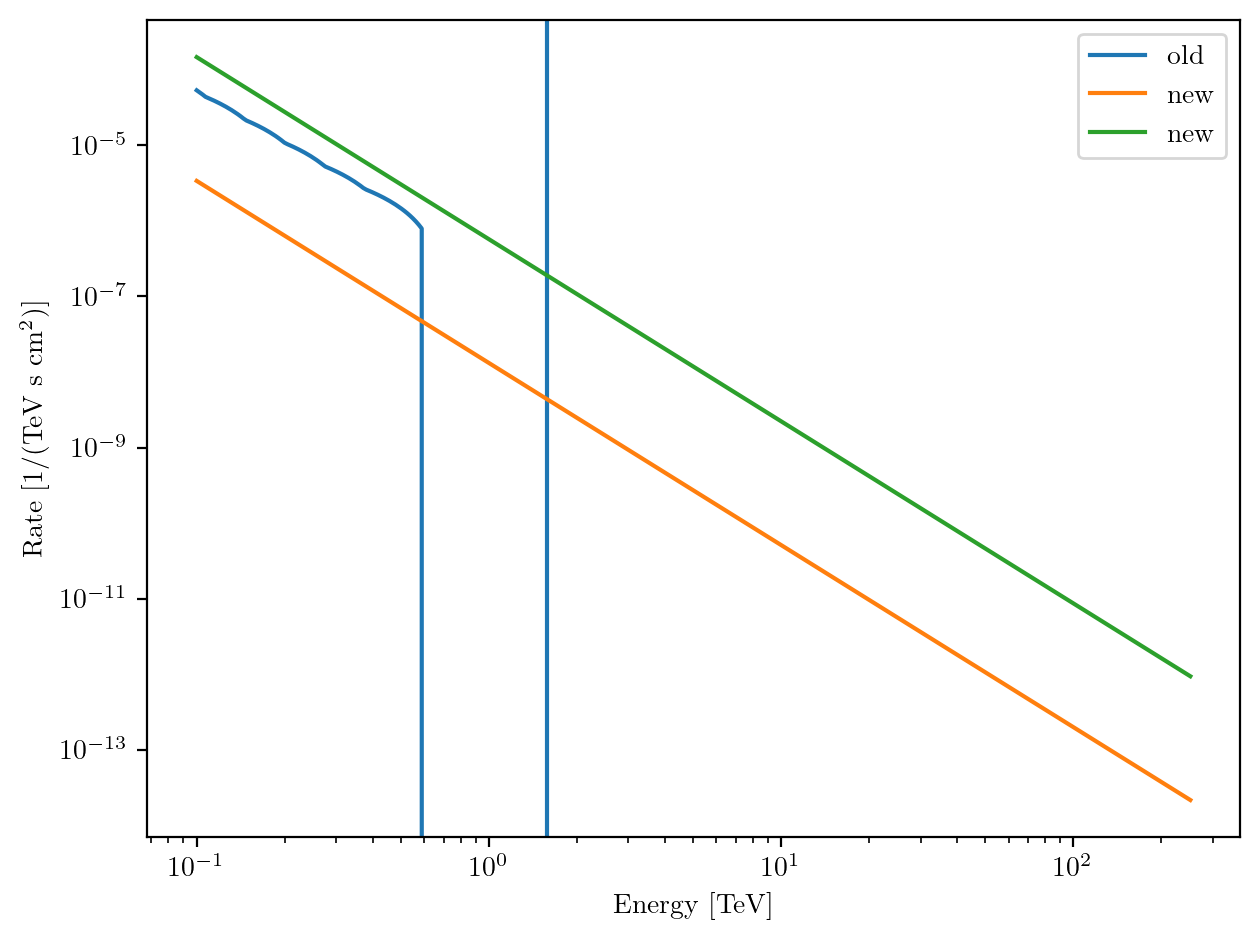

In [23]:

plt.figure(dpi=200)
cutoff = 120
vals = simps(y=simps(y=fermievaluated[:cutoff,:,:], x= longitudeaxistrue, axis=1), x = latitudeaxistrue, axis=1)
fit = interpolate.interp1d(y=np.log(vals), x=log10eaxistrue[:cutoff], bounds_error=False, fill_value='extrapolate')
# plt.plot(10**log10eaxistrue[:cutoff], vals)
plt.plot(10**log10eaxistrue, np.exp(fit(log10eaxistrue)), label='old')
plt.axvline(10**log10eaxistrue[cutoff])
plt.plot(10**log10eaxistrue, simps(y=simps(y=fermifull, x= longitudeaxistrue, axis=1), x = latitudeaxistrue, axis=1), label='new')
plt.plot(10**log10eaxistrue, powerlaw(10**log10eaxistrue, index=-2.41, phi0=1.36*1e-8)*(longitudeaxistrue[-1]-longitudeaxistrue[0])*(latitudeaxistrue[-1]-latitudeaxistrue[0]), label='new')
plt.loglog()
plt.xlabel('Energy [TeV]')
plt.ylabel(r'Rate [1/(TeV s cm$^2$)]')
plt.legend()
plt.tight_layout()
plt.show()

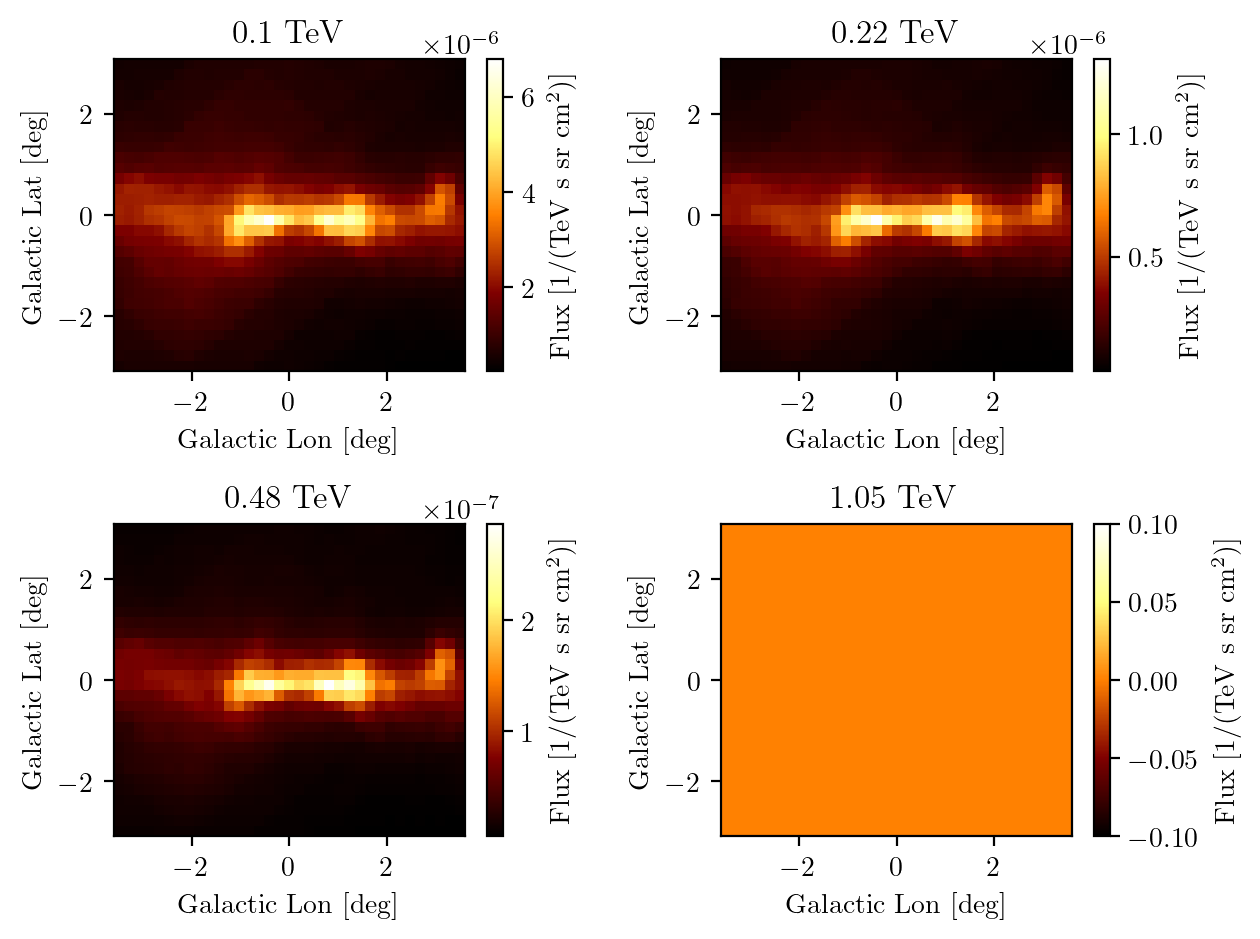

In [24]:

plt.figure(dpi=200)

counter=1
for idx in np.arange(0, log10eaxistrue.shape[0], int(log10eaxistrue.shape[0]/10)):
    plt.subplot(2,2,counter)
    plt.title(f'{round(10**log10eaxistrue[idx],2)} TeV')
    plt.pcolormesh(fermilonaxis, fermilataxis, fermievaluated[idx].T, cmap='afmhot')
    plt.colorbar(label=r'Flux [1/(TeV s sr cm$^2$)]')
    plt.xlabel('Galactic Lon [deg]')
    plt.ylabel('Galactic Lat [deg]')
    counter+=1
    if counter>4:
        break

plt.tight_layout()
plt.show()

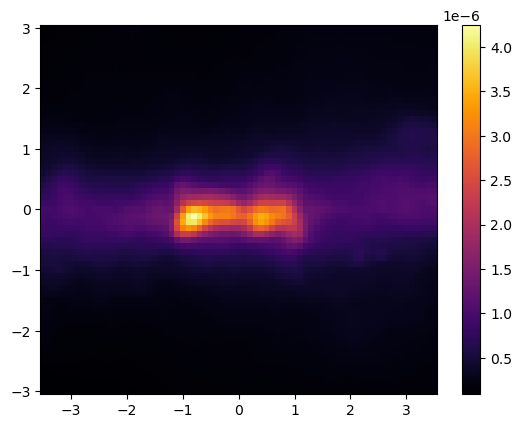

In [25]:
fermiunit = fermievaluated.unit
fermiunit

Unit("1 / (cm2 s sr TeV)")

In [26]:
fermienergyvals = energy_axis_true.center.value
fermienergyvals

array([1.00000000e-01, 1.02329299e-01, 1.04712855e-01, 1.07151931e-01,
       1.09647820e-01, 1.12201845e-01, 1.14815362e-01, 1.17489755e-01,
       1.20226443e-01, 1.23026877e-01, 1.25892541e-01, 1.28824955e-01,
       1.31825674e-01, 1.34896288e-01, 1.38038426e-01, 1.41253754e-01,
       1.44543977e-01, 1.47910839e-01, 1.51356125e-01, 1.54881662e-01,
       1.58489319e-01, 1.62181010e-01, 1.65958691e-01, 1.69824365e-01,
       1.73780083e-01, 1.77827941e-01, 1.81970086e-01, 1.86208714e-01,
       1.90546072e-01, 1.94984460e-01, 1.99526231e-01, 2.04173794e-01,
       2.08929613e-01, 2.13796209e-01, 2.18776162e-01, 2.23872114e-01,
       2.29086765e-01, 2.34422882e-01, 2.39883292e-01, 2.45470892e-01,
       2.51188643e-01, 2.57039578e-01, 2.63026799e-01, 2.69153480e-01,
       2.75422870e-01, 2.81838293e-01, 2.88403150e-01, 2.95120923e-01,
       3.01995172e-01, 3.09029543e-01, 3.16227766e-01, 3.23593657e-01,
       3.31131121e-01, 3.38844156e-01, 3.46736850e-01, 3.54813389e-01,
      

In [27]:
fermievaluated[0,0,0]

<Quantity 5.41328185e-07 1 / (cm2 s sr TeV)>

# Adding the two astrophysical components together

In [28]:
fermiplotmap = fermievaluated.value
combinedplotmap = fermifull #+ np.flip(fullhessdataset, axis=1)

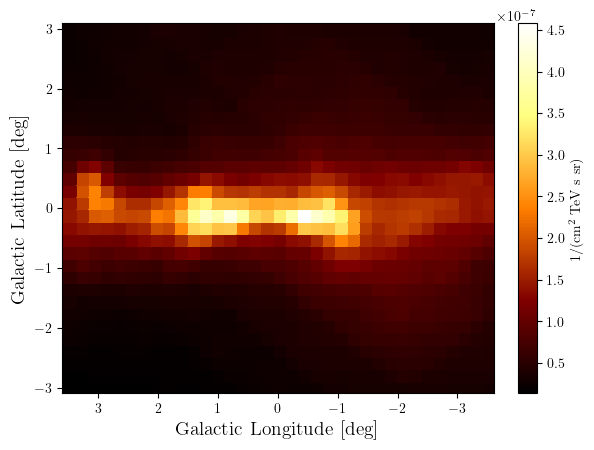

In [29]:


fig6, ax = plt.subplots()
pcol = plt.pcolormesh(fermilonaxis, fermilataxis, np.max(combinedplotmap,axis=0).T, cmap='afmhot', shading='auto')#, norm=LogNorm(vmin=1e-6, vmax=5e-5))
pcol.set_edgecolor('face')

plt.xlabel("Galactic Longitude [deg]", size=14)
ax.invert_xaxis()

plt.ylabel("Galactic Latitude [deg]", size=14)
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(cm$^2$ TeV s sr)")
plt.savefig('Figures/Diffuse_BKG_Spatial_Map.pdf')
plt.show()

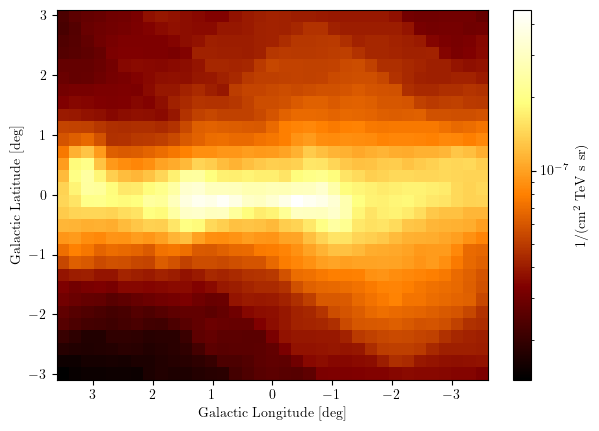

In [30]:
fig6, ax = plt.subplots(dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, np.max(combinedplotmap,axis=0).T, cmap='afmhot', norm=LogNorm())#, vmax=1e-5)
plt.xlabel("Galactic Longitude [deg]")
ax.invert_xaxis()
plt.ylabel("Galactic Latitude [deg]")
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(cm$^2$ TeV s sr)")

plt.show()

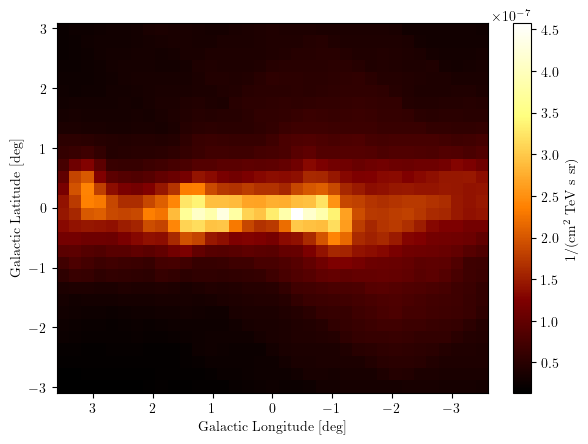

In [31]:
fig6, ax = plt.subplots(dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, np.max(combinedplotmap,axis=0).T, cmap='afmhot')#, vmax=1e-5)
plt.xlabel("Galactic Longitude [deg]")
ax.invert_xaxis()
plt.ylabel("Galactic Latitude [deg]")
ax.set_aspect(1)
plt.colorbar(fraction=0.05, label=r"1/(cm$^2$ TeV s sr)")

plt.show()

In [32]:
combinedplotmap.shape

(341, 35, 30)

In [33]:
from utils3d import irfs

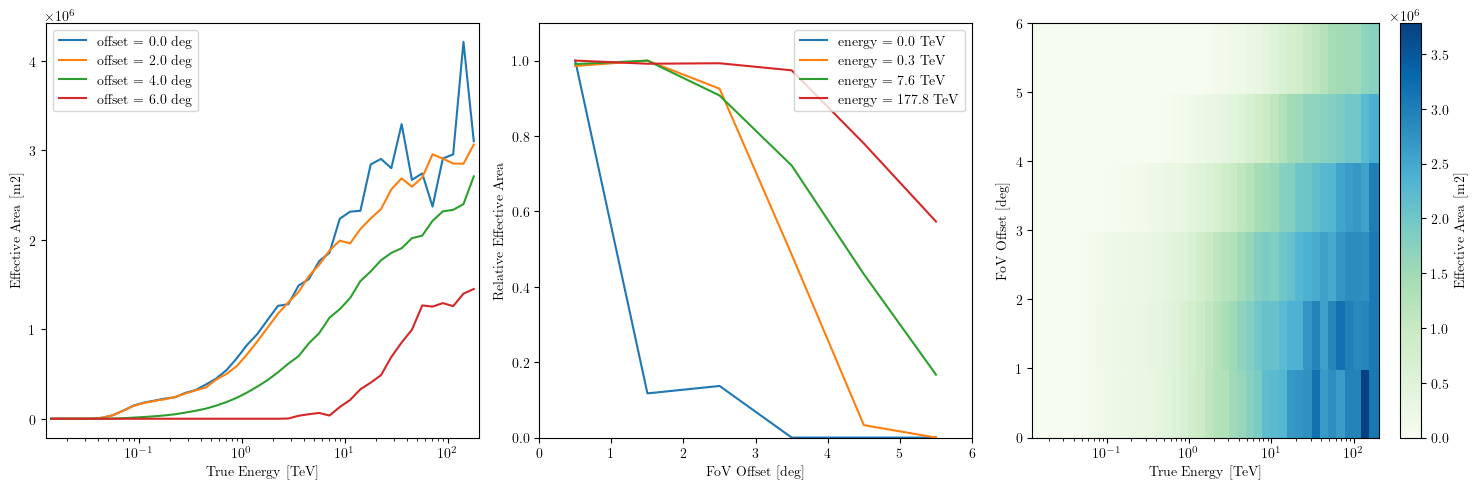

In [34]:
aeff = irfs['aeff']
aeff.peek()

In [35]:
aefffunc = lambda energy, offset: aeff.evaluate(energy_true = energy*u.TeV, offset=offset*u.deg).to(u.cm**2).value

In [36]:
aeff.evaluate(energy_true = 1*u.TeV, offset=0.5*u.deg)/1e5

<Quantity 7.35946814 m2>

In [37]:
aefffunc(1.0, 0.5)/1e9

7.359468135925809

In [38]:
lonmesh, energymesh, latmesh = np.meshgrid(longitudeaxistrue, 10**log10eaxistrue, latitudeaxistrue)
print(lonmesh.shape)

(341, 35, 30)


In [39]:
aefftable = aefffunc(energymesh, np.sqrt((lonmesh**2)+(latmesh**2)))

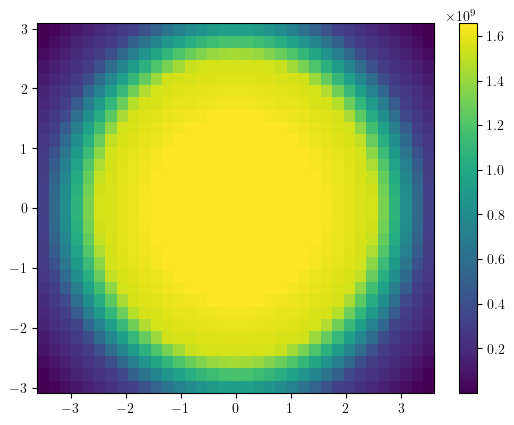

In [40]:
plt.pcolormesh(fermilonaxis, fermilataxis, aefftable[0,:,:].T)
plt.colorbar()
plt.show()

In [41]:
# aefftable[75,250,250]

In [42]:
# fermilataxis[250]

In [43]:
# aefffunc(fermienergyvals[75], np.sqrt(fermilonaxis[250]**2+fermilataxis[250]**2))

In [44]:
np.log(fermienergyvals[1:]-fermienergyvals[:-1])

array([-6.06218782, -6.03916197, -6.01613612, -5.99311026, -5.97008441,
       -5.94705856, -5.92403271, -5.90100686, -5.87798101, -5.85495516,
       -5.83192931, -5.80890346, -5.78587761, -5.76285176, -5.7398259 ,
       -5.71680005, -5.6937742 , -5.67074835, -5.6477225 , -5.62469665,
       -5.6016708 , -5.57864495, -5.5556191 , -5.53259325, -5.50956739,
       -5.48654154, -5.46351569, -5.44048984, -5.41746399, -5.39443814,
       -5.37141229, -5.34838644, -5.32536059, -5.30233474, -5.27930889,
       -5.25628303, -5.23325718, -5.21023133, -5.18720548, -5.16417963,
       -5.14115378, -5.11812793, -5.09510208, -5.07207623, -5.04905038,
       -5.02602453, -5.00299867, -4.97997282, -4.95694697, -4.93392112,
       -4.91089527, -4.88786942, -4.86484357, -4.84181772, -4.81879187,
       -4.79576602, -4.77274017, -4.74971431, -4.72668846, -4.70366261,
       -4.68063676, -4.65761091, -4.63458506, -4.61155921, -4.58853336,
       -4.56550751, -4.54248166, -4.5194558 , -4.49642995, -4.47

# Adding the Aeff to the map

In [45]:
combinedplotmapwithaeff = combinedplotmap*aefftable
combinedplotmapwithaeff = combinedplotmapwithaeff
topbound=1e1000
combinedplotmapwithaeff[combinedplotmapwithaeff>topbound] = topbound
normalisation = np.sum(combinedplotmapwithaeff.T*10**log10eaxistrue*np.log(10)*(log10eaxistrue[1]-log10eaxistrue[0]))
# combinedplotmapwithaeff=combinedplotmapwithaeff/normalisation
# modtopbound = topbound/normalisation
spatialplotcombined = np.sum((combinedplotmapwithaeff.T*10**log10eaxistrue*np.log(10)*(log10eaxistrue[1]-log10eaxistrue[0])).T, axis=0)
spatialplotcombinedmaxvalue = np.max(spatialplotcombined)

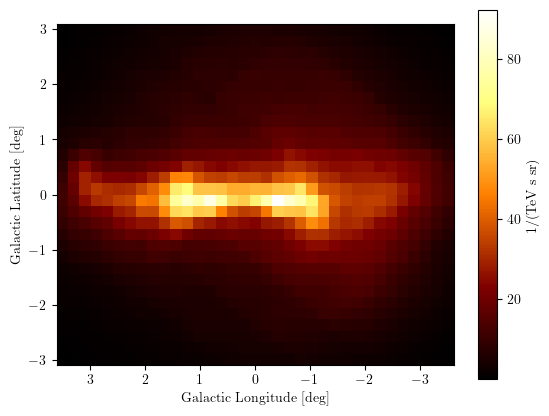

In [46]:
fig, ax = plt.subplots(1,1, dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, spatialplotcombined.T, vmax=spatialplotcombinedmaxvalue, vmin=spatialplotcombinedmaxvalue/1e4, cmap='afmhot')
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.invert_xaxis()
plt.colorbar(label = r"1/(TeV s sr)")
ax.set_aspect(1)

plt.show()

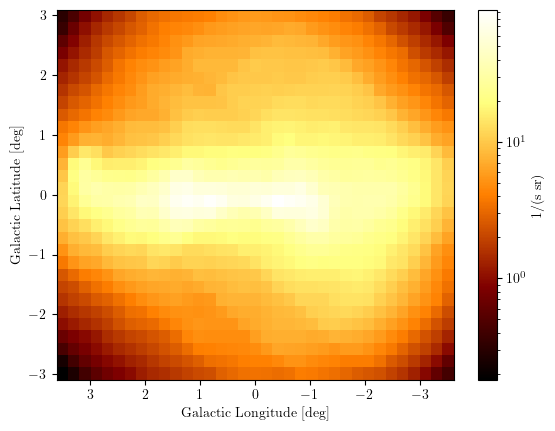

In [47]:
fig, ax = plt.subplots(1,1, dpi=100)
plt.pcolormesh(fermilonaxis, fermilataxis, spatialplotcombined.T, norm=LogNorm(), cmap='afmhot')
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.invert_xaxis()
plt.colorbar(label = r"1/(s sr)")

plt.show()

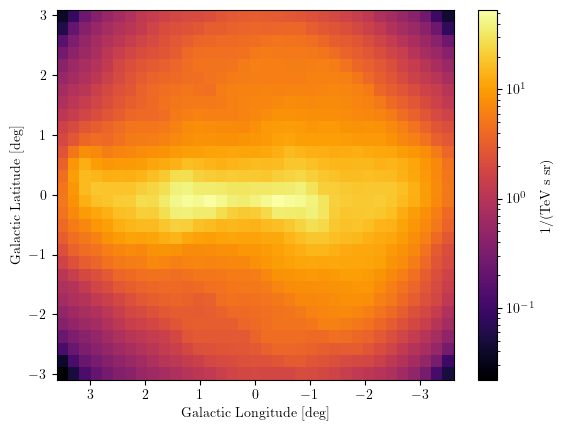

In [48]:
fig, ax = plt.subplots(1,1)
plt.pcolormesh(fermilonaxis, fermilataxis, np.mean(combinedplotmapwithaeff, axis=0).T, norm=LogNorm(), cmap='inferno')
plt.xlabel("Galactic Longitude [deg]")
plt.ylabel("Galactic Latitude [deg]")
ax.invert_xaxis()
plt.colorbar(label = r"1/(TeV s sr)")
plt.show()

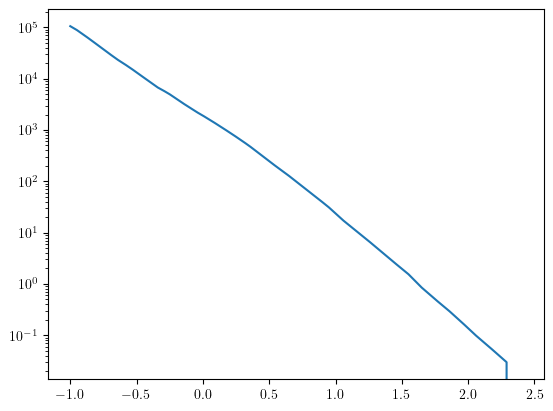

In [49]:
fig, ax = plt.subplots(1,1)
plt.plot(log10eaxistrue, np.sum(combinedplotmapwithaeff, axis=(1,2)))
plt.yscale('log')
plt.show()

In [50]:
np.min(combinedplotmapwithaeff)

0.0

In [51]:
np.save("unnormalised_astrophysicalbackground.npy", combinedplotmapwithaeff)

In [52]:
simps(y=simps(y=simps(y=combinedplotmapwithaeff, x=10**log10eaxistrue, axis=0), x = longitudeaxistrue, axis=0), x=latitudeaxistrue)/1.08e8

5.2730126893442485e-06

In [53]:
fermilataxis

array([-2.98529412, -2.77941176, -2.57352941, -2.36764706, -2.16176471,
       -1.95588235, -1.75      , -1.54411765, -1.33823529, -1.13235294,
       -0.92647059, -0.72058824, -0.51470588, -0.30882353, -0.10294118,
        0.10294118,  0.30882353,  0.51470588,  0.72058824,  0.92647059,
        1.13235294,  1.33823529,  1.54411765,  1.75      ,  1.95588235,
        2.16176471,  2.36764706,  2.57352941,  2.77941176,  2.98529412])

In [54]:
longitudeaxistrue.shape

(35,)

In [55]:
combinedplotmapwithaeff.shape

(341, 35, 30)

In [56]:
simps(y=simps(y=simps(y=combinedplotmapwithaeff, x=10**log10eaxistrue,axis=0), x=longitudeaxistrue, axis=0), x=latitudeaxistrue)*60*60*525/1e8

10.76327350148948

In [61]:
import pandas as pd
# data = pd.read_csv("CR_BKG.csv")
# data = np.asarray(data)

In [62]:

# bkginterp = interpolate.interp1d(x = data[:,0],y = 1.1*data[:,1], bounds_error=False, fill_value="extrapolate", kind='linear')

In [63]:
# plt.figure()
# plt.plot(data[:,0],data[:,1], c='tab:green', ls='--')
# plt.plot(data[:,0],bkginterp(data[:,0]), c='tab:orange', ls=':')
# plt.loglog()
# plt.show()

In [64]:
# bkginterp(30),

In [65]:
# gev_energy_range = np.logspace(np.log10(30), np.log10(100000), 55)
# gev_energy_range
# bkginterpdata = bkginterp(gev_energy_range)

In [67]:
# plt.figure()
# plt.plot(data[:,0],data[:,1], c='tab:green', ls='--')
# plt.plot(data[:,0],bkginterp(data[:,0]), c='tab:orange', ls=':')
# plt.plot(gev_energy_range,bkginterpdata, c='tab:red', ls='-.')

# plt.loglog()
# plt.show()

In [68]:


# simps(y=bkginterpdata/gev_energy_range, x=gev_energy_range)/1.08e8

In [69]:
# bkginterpdata

In [70]:

from gammapy.astro.darkmatter import (
    profiles,
    JFactory
)

profile = profiles.EinastoProfile()

# Adopt standard values used in HESS
profiles.DMProfile.DISTANCE_GC = 8.5 * u.kpc
profiles.DMProfile.LOCAL_DENSITY = 0.39 * u.Unit("GeV / cm3")

profile.scale_to_local_density()

position = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
geom = WcsGeom.create(skydir=position, 
                      binsz=longitudeaxistrue[1]-longitudeaxistrue[0],
                      width=(longitudeaxistrue[-1]-longitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0], latitudeaxistrue[-1]-latitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0]),
                      frame="galactic")

In [71]:
jfactory = JFactory(
    geom=geom, profile=profile, distance=profiles.DMProfile.DISTANCE_GC
)
jfact = jfactory.compute_differential_jfactor()

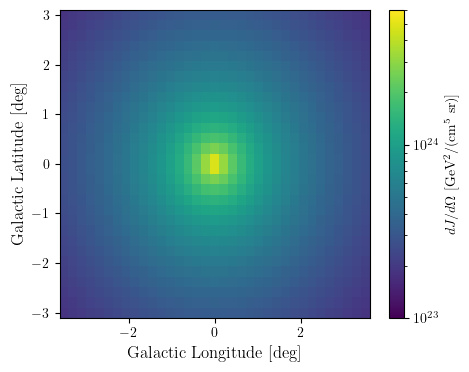

In [72]:
plt.figure(figsize=(5,4))
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, jfact, norm=LogNorm(vmin=1e23, vmax=6e24))
plt.colorbar(label=r'$dJ/d\Omega$ [GeV$^2$/(cm$^5$ sr)]')
plt.xlabel('Galactic Longitude [deg]', size=12)
plt.ylabel('Galactic Latitude [deg]', size=12)
plt.savefig('Figures/Einasto_dJdW.pdf')
plt.show()

In [73]:
jfact.value

array([[1.84534719e+23, 1.93437257e+23, 2.02740852e+23, ...,
        2.02740852e+23, 1.93437257e+23, 1.84534719e+23],
       [1.92023532e+23, 2.01794382e+23, 2.12071189e+23, ...,
        2.12071189e+23, 2.01794382e+23, 1.92023532e+23],
       [1.99624562e+23, 2.10330368e+23, 2.21666635e+23, ...,
        2.21666635e+23, 2.10330368e+23, 1.99624562e+23],
       ...,
       [1.99624562e+23, 2.10330368e+23, 2.21666635e+23, ...,
        2.21666635e+23, 2.10330368e+23, 1.99624562e+23],
       [1.92023532e+23, 2.01794382e+23, 2.12071189e+23, ...,
        2.12071189e+23, 2.01794382e+23, 1.92023532e+23],
       [1.84534719e+23, 1.93437257e+23, 2.02740852e+23, ...,
        2.02740852e+23, 1.93437257e+23, 1.84534719e+23]])

In [74]:
from utils3d import bkgdist

lonmeshtrue, log10emeshtrue, latmeshtrue = np.meshgrid(longitudeaxistrue, log10eaxistrue, latitudeaxistrue)

logbkgpriorvalues = np.squeeze(np.logaddexp(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue),np.log(combinedplotmapwithaeff)))
logbkgpriorvalues.shape

(341, 35, 30)

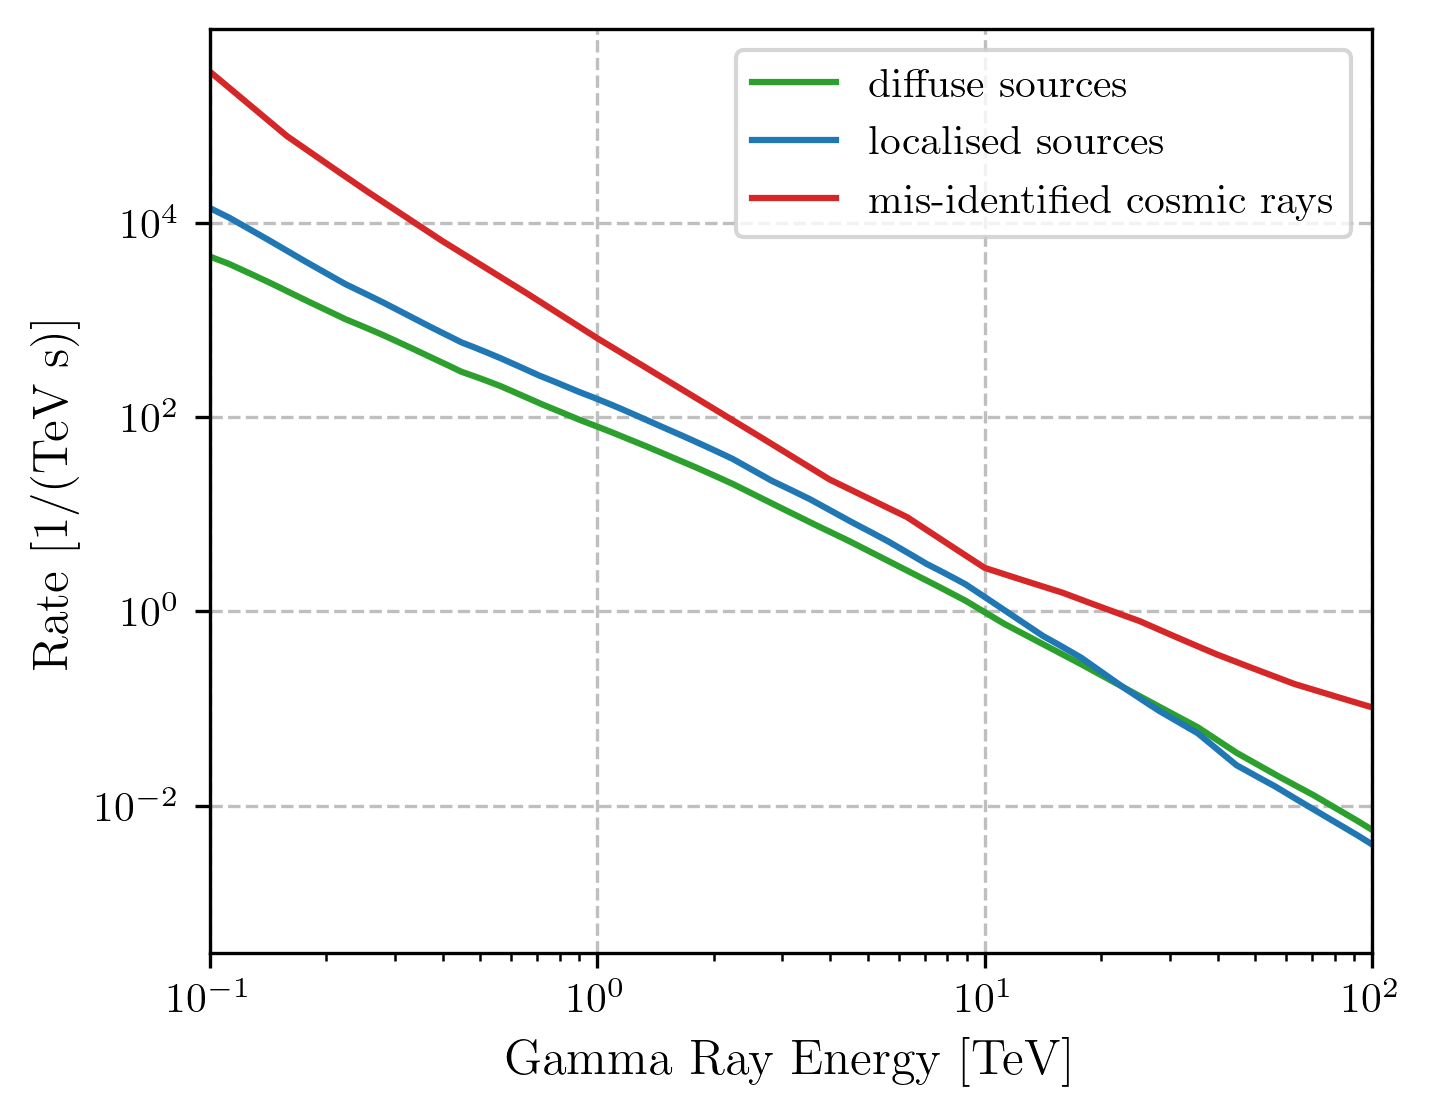

In [80]:
plt.figure(figsize=(5,4), dpi=300)
# plt.plot(log10eaxistrue, np.mean(logbkgpriorvalues, axis=(1,2)), c='tab:blue')
plt.plot(10**log10eaxistrue, simps(y=simps(y=fermifull*aefftable, x=longitudeaxistrue, axis=1), 
                                   x=latitudeaxistrue, axis=1), 
         c="tab:green", label='diffuse sources')
plt.plot(10**log10eaxistrue, simps(y=simps(y=np.flip(fullhessdataset, axis=1)*aefftable, x=longitudeaxistrue, axis=1), 
                                   x=latitudeaxistrue, axis=1), 
         c="tab:blue", label='localised sources')
plt.plot(10**log10eaxistrue, simps(y=simps(y=np.exp(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)), 
                                                    x=longitudeaxistrue, axis=1), x=latitudeaxistrue, axis=1), 
                                   c="tab:red", label='mis-identified cosmic rays')

plt.xlim([1e-1,1e2])

plt.loglog()
plt.xlabel(r"Gamma Ray Energy [TeV]", size=12)
plt.ylabel(r"Rate [1/(TeV s)]", size=12)
plt.legend()
plt.grid(ls='--', c='grey', alpha=0.5)
plt.savefig('Figures/integrated_bkg_spectra.pdf')
plt.show()

In [ ]:
from utils3d import bkgfull

In [ ]:
bkgfull.evaluate(energy=10**0*u.TeV, fov_lon=1.0*u.deg, fov_lat=1.0*u.deg).to(1/(u.TeV*u.s*u.sr))

<Quantity 116.55200141 1 / (s sr TeV)>